# <font style="color:blue">Project 2: Kaggle Competition - Classification</font>

#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Data Loader</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Configuration</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Evaluation Metric</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>Train and Validation</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Model</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>Utils</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>Experiment</h3></td><td><h3>5</h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>TensorBoard Dev Scalars Log Link</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>9</h3></td> <td><h3>Kaggle Profile Link</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>


## <font style="color:green">1. Data Loader [10 Points]</font>

In this section, you have to write a class or methods that will be used to get training and validation data
loader.

You will have to write a custom dataset class to load data.

**Note that there are not separate validation data, so you will have to create your validation set by dividing train data into train and validation data. Usually, in practice, we do `80:20` ratio for train and validation, respectively.** 

For example,

```
class KenyanFood13Dataset(Dataset):
    """
    
    """
    
    def __init__(self, *args):
    ....
    ...
    
    def __getitem__(self, idx):
    ...
    ...
    
    
```

```
def get_data(args1, *agrs):
    ....
    ....
    return train_loader, test_loader
```

In [1]:
import os
import time
import torch
import pandas as pd
from skimage import io, transform
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms, utils, models
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
from dataclasses import dataclass


In [2]:
def configureSystem():
    '''
    Describes the common system setting needed for reproducible training
    '''
    torch.manual_seed(21)
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        torch.backends.cudnn_benchmark_enabled = True
        torch.backends.cudnn.deterministic = True

In [3]:
class KenyanFood13Dataset(Dataset):
    """

    """
        
    def __init__(self, csv_file, root_dir, suffix, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root = root_dir
        self.suffix = suffix
        self.transform = transform
        self.classes = list(self.data['class'].unique())

    def __getitem__(self, idx):
        img_name = os.path.join(self.root, str(self.data.iloc[idx, 0]) + self.suffix)
        
        image = Image.open(img_name)
        
        # String target
        # target = self.data.iloc[idx, 1]
        
        # target as id (0,1,2,3...12)
        target = self.class_to_index(self.data.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, target
    
    
    def class_to_index(self, class_name):
        return self.classes.index(class_name)
    
    
    def index_to_class(self, class_index):
        return self.classes[class_index]
    
    
    def __len__(self):
        return len(self.data)


In [4]:
# Used to apply transforms to training and validation data
class KenyanFood13Subset(KenyanFood13Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform


    def __getitem__(self, idx):
        img, target = self.subset[idx]
        if self.transform:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self.subset)

In [5]:
# Used to make predictions
class KenyanFood13Testset(Dataset):
    def __init__(self, csv_file, root_dir, suffix, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root = root_dir
        self.suffix = suffix
        self.transform = transform


    def __getitem__(self, idx):
        img_name = os.path.join(self.root, str(self.data.iloc[idx, 0]) + self.suffix)
        
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image
    
    def __len__(self):
        return len(self.data)

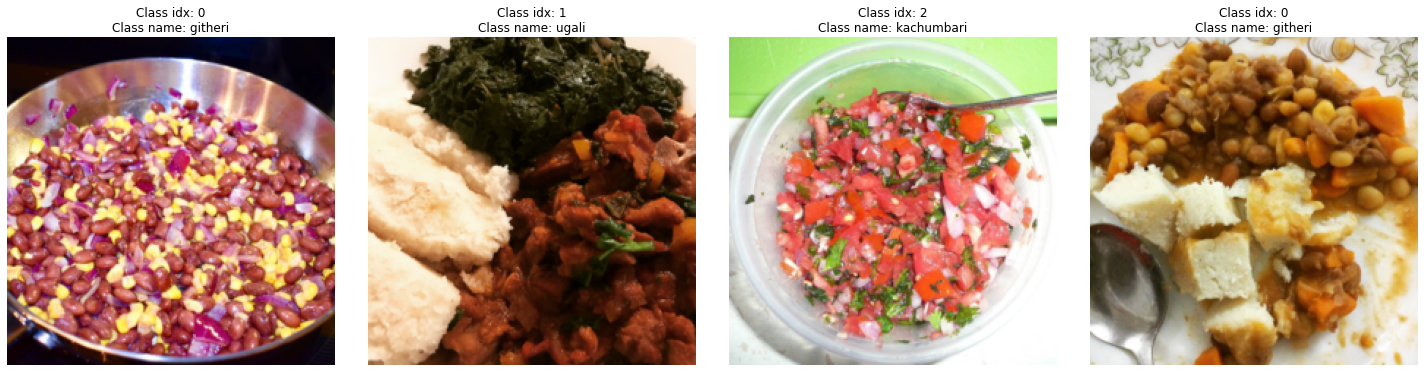

In [6]:
# Testing Dataset
data_path = '/kaggle/input/pytorch-opencv-course-classification/images/images/'
csv_path = '/kaggle/input/pytorch-opencv-course-classification/train.csv'

dataset = KenyanFood13Dataset(csv_file=csv_path,
                                       root_dir=data_path,
                                       suffix='.jpg',
                                       transform=transforms.Compose([
                                           transforms.Resize(224),
                                           transforms.CenterCrop(224),
                                           ]))

plt.figure(figsize=(20,15))

for i in range(len(dataset)):
    img, label = dataset[i]
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(f'Class idx: {label}\nClass name: {dataset.index_to_class(label)}')
    ax.axis('off')
    plt.imshow(img)
    if i == 3:
        plt.show()
        break

In [7]:
def get_mean_std(dataset, num_workers=4):

    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor()
        ])
    
    loader = DataLoader(dataset, batch_size=10, shuffle=False, num_workers=2)

    mean = 0.
    std = 0.
    
    for images, _ in loader:
        batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

    mean /= len(loader.dataset)
    std /= len(loader.dataset)
    
    print('mean: {}, std: {}'.format(mean, std))
    
    return mean, std


Data Augmentation is turned ON!
Training Data: 5228
Validation Data: 1308
Number of classes: 13

Data per class (before split):
chapati        862
nyamachoma     784
bhaji          632
ugali          628
mandazi        620
kachumbari     494
matoke         483
githeri        479
masalachips    438
sukumawiki     402
pilau          329
mukimo         212
kukuchoma      173
Name: class, dtype: int64


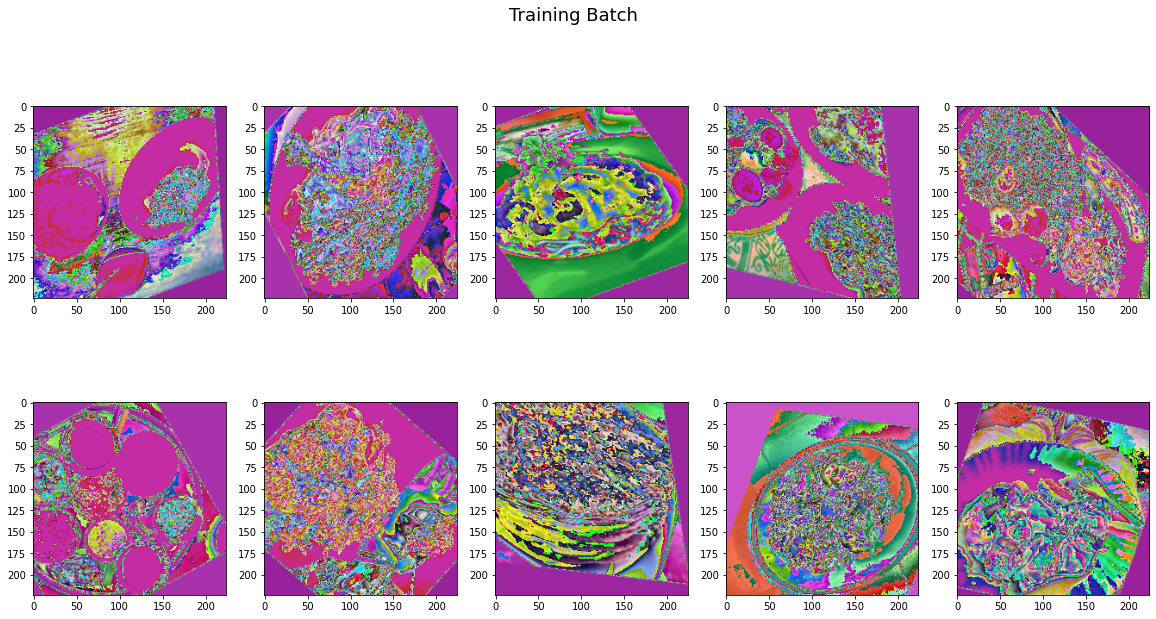

In [8]:
def get_data(root_path, batch_size, num_workers=2, augmentation=False):
    
    dataset = KenyanFood13Dataset(csv_file=root_path + 'train.csv',
                                       root_dir=root_path + 'images/images/',
                                       suffix='.jpg')

    # Used to get the mean and std of the dataset
    
    # mean, std = get_mean_std(dataset)
    
    preprocess = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5768, 0.4622, 0.3460], [0.2383, 0.2464, 0.2465])
    ])
    
    if augmentation:
        train_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomAffine(degrees=60, translate=(0.15, 0.15), shear=20),
            transforms.ColorJitter(brightness=0.5, contrast=0.2, saturation=0.4),
            preprocess
        ])
        print("Data Augmentation is turned ON!")
    else:
        train_transforms = preprocess
    
    # Split into training and validation sets
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    
    
    # Apply Data Transform
    train_dataset = KenyanFood13Subset(train_dataset, train_transforms)
    test_dataset = KenyanFood13Subset(test_dataset, preprocess)

    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    return train_loader, test_loader


#########TEST#######
batch_size = 10
train_loader, test_loader = get_data('/kaggle/input/pytorch-opencv-course-classification/', batch_size, 2, True)

print('Training Data: {}\nValidation Data: {}'.format(len(train_loader.dataset),len(test_loader.dataset)))

print('Number of classes: {}'.format(len(train_loader.dataset.subset.dataset.data['class'].value_counts())))

print('\nData per class (before split):')
print(train_loader.dataset.subset.dataset.data['class'].value_counts())


piltr = transforms.ToPILImage()

fig = plt.figure(figsize=(20,10))
fig.suptitle('Training Batch', fontsize=18)

for i in range(batch_size):

    img, target = train_loader.dataset[i]
    
    
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(piltr(img))

## <font style="color:green">2. Configuration [5 Points]</font>

Define your configuration in this section.

For example,

```
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 10 
    epochs_count: int = 50  
    init_learning_rate: float = 0.1  # initial learning rate for lr scheduler
    log_interval: int = 5  
    test_interval: int = 1  
    data_root: str = "/kaggle/input/pytorch-opencv-course-classification/" 
    num_workers: int = 2  
    device: str = 'cuda'  
    
```

In [9]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 16
    epochs_count: int = 30
    init_learning_rate: float = 0.0001  # initial learning rate for lr scheduler
    log_interval: int = 5  
    test_interval: int = 1  
    root_path: str = "/kaggle/input/pytorch-opencv-course-classification/"
    num_workers: int = 4
    device: str = 'cuda'
    input_size = 224
    num_classes = 13

## <font style="color:green">3. Evaluation Metric [10 Points]</font>

Define methods or classes that will be used in model evaluation, for example, accuracy, f1-score, etc.

In [10]:
class F1_Loss(nn.Module):
    '''Calculate F1 score. Can work with gpu tensors
    
    The original implmentation is written by Michal Haltuf on Kaggle.
    
    Returns
    -------
    torch.Tensor
        `ndim` == 1. epsilon <= val <= 1
    
    Reference
    ---------
    - https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
    - https://discuss.pytorch.org/t/calculating-precision-recall-and-f1-score-in-case-of-multi-label-classification/28265/6
    - http://www.ryanzhang.info/python/writing-your-own-loss-function-module-for-pytorch/
    '''
    def __init__(self, epsilon=1e-7):
        super().__init__()
        self.epsilon = epsilon
        
    def forward(self, y_pred, y_true,):
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        y_true = F.one_hot(y_true, 2).to(torch.float32)
        y_pred = F.softmax(y_pred, dim=1)
        
        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2* (precision*recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1-self.epsilon)
        return 1 - f1.mean()

f1_loss = F1_Loss().cuda()
    

## <font style="color:green">4. Train and Validation [5 Points]</font>

Write the methods or classes that will be used for training and validation.

In [11]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> None:
    
    # change model in training mood
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        # clone target
        indx_target = target.clone()
        # send data to device (its is medatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gardients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    print('Epoch: {} \nTrain Loss: {:.6f} Acc: {:.4f}'.format(epoch_idx, epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc

In [12]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    # 
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:

        indx_target = target.clone()

        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    
    return test_loss, accuracy/100.0

## <font style="color:green">5. Model [5 Points]</font>

Define your model in this section.

**You are allowed to use any pre-trained model.**

In [13]:
def trainable_parameters(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name)

In [14]:
def pretrained_mobilenet(num_class):
    
    if not os.path.exists('/kaggle/working/models'):
        os.makedirs('/kaggle/working/models')

    try:
        model = torch.load('/kaggle/working/models/mobilenet_pretrained.pt')
    except FileNotFoundError:
        model = models.mobilenet_v2(pretrained=True)

        torch.save(model, '/kaggle/working/models/mobilenetv2_pretrained.pt')
        model = torch.load('/kaggle/working/models/mobilenetv2_pretrained.pt')
        
    # Freeze parameters
    for param in model.parameters():
        param.requires_grad = False
        
        
    # Unfreeze last convolution block (4/4 parameters)
    for param in model.features[18].parameters():
        param.requires_grad = True
    
        # Replace last layer
    model.classifier = nn.Sequential(
        nn.Linear(1280, 256),
        nn.ReLU(),
        nn.Linear(256, num_class)
    )
    
    model.classifier.requires_grad = True

    
    return model

# print(pretrained_inception3(13))
# TEST

# inception.eval()
# img, target = train_loader.dataset[0]

# preInference = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize(299),
#     transforms.CenterCrop(299),
#     transforms.ToTensor()
# ])

# img = preInference(img)
# input_batch = img.unsqueeze(0)
# input_batch = input_batch.to('cpu')
# with torch.no_grad():
#   output = inception(input_batch)

# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
# print(torch.nn.functional.softmax(output[0], dim=0))


In [15]:
def pretrained_resnet50(num_class):
    # Make models folder
    if not os.path.exists('/kaggle/working/models'):
        os.makedirs('/kaggle/working/models')
        
    # Load/Download model
    try:
        model = torch.load('/kaggle/working/models/resnet50_pretrained.pt')
    except FileNotFoundError:
        model = models.wide_resnet50_2(pretrained=True)
        torch.save(model, '/kaggle/working/models/resnet50_pretrained.pt')
        model = torch.load('/kaggle/working/models/resnet50_pretrained.pt')
        
    # Freeze    
    for param in model.parameters():
        param.requires_grad = False
        
    # Replace last layer
    model.fc = nn.Sequential(
        nn.Linear(2048, 256),
        nn.ReLU(),
        nn.Linear(256, num_class)
    )
    
    # Unfreeze prior to last layer (3/9 parameters)
#     num_param = 0
#     for param in model.layer4[2].parameters():
#         if num_param>=6:
#             param.requires_grad = True
#         num_param+=1
        
    # Unfreeze prior to last layer (9/9 parameters)
#     for param in model.layer4[2].parameters():
#         param.requires_grad = True

    # Unfreeze testing  
    for param in model.layer3.parameters():
        param.requires_grad = True
        
    for param in model.layer4.parameters():
        param.requires_grad = True
    
    return model

# Test
trainable_parameters(pretrained_resnet50(13))

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/checkpoints/wide_resnet50_2-95faca4d.pth



layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.conv3.weight
layer3.0.bn3.weight
layer3.0.bn3.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer3.1.conv3.weight
layer3.1.bn3.weight
layer3.1.bn3.bias
layer3.2.conv1.weight
layer3.2.bn1.weight
layer3.2.bn1.bias
layer3.2.conv2.weight
layer3.2.bn2.weight
layer3.2.bn2.bias
layer3.2.conv3.weight
layer3.2.bn3.weight
layer3.2.bn3.bias
layer3.3.conv1.weight
layer3.3.bn1.weight
layer3.3.bn1.bias
layer3.3.conv2.weight
layer3.3.bn2.weight
layer3.3.bn2.bias
layer3.3.conv3.weight
layer3.3.bn3.weight
layer3.3.bn3.bias
layer3.4.conv1.weight
layer3.4.bn1.weight
layer3.4.bn1.bias
layer3.4.conv2.weight
layer3.4.bn2.weight
layer3.4.bn2.bias
layer3.4.conv3.weight
layer3.4.bn3.weight
layer3.4.bn3.bias
layer3.5.conv1

## <font style="color:green">6. Utils [5 Points]</font>

Define your methods or classes which are not covered in the above sections.

In [16]:
def save_model(model, device, accuracy, model_dir='/kaggle/working/models/', model_file_name='resnet50_Retrained'):


    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # make sure you transfer the model to cpu.
    if device == 'cuda':
        model.to('cpu')

    # save the state_dict
    torch.save(model.state_dict(), model_path + (str(accuracy)[6:]) + '.pt' )

    if device == 'cuda':
        model.to('cuda')

    return

def load_model(model, model_dir='/kaggle/working/models/', model_file_name='resnet50_Retrained(0.7760).pt'):
    model_path = os.path.join(model_dir, model_file_name)

    # loading the model and getting model parameters by using load_state_dict
    model.load_state_dict(torch.load(model_path))

    return model

## <font style="color:green">7. Experiment [5 Points]</font>

Choose your optimizer and LR-scheduler and use the above methods and classes to train your model.

In [17]:
def main(model, optimizer, tb_writer, scheduler=None,
         training_configuration=TrainingConfiguration(), data_augmentation=True):

     # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config,
    # else lowers batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        training_configuration.device = "cpu"
        batch_size_to_set = 12
        num_workers_to_set = 2
        
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
        
    print(f"Training on: {training_configuration.device}")

    train_loader, test_loader = get_data(root_path=training_configuration.root_path, batch_size=training_configuration.batch_size, num_workers=training_configuration.num_workers, augmentation=data_augmentation)

    model.to(training_configuration.device)

    best_loss = torch.tensor(np.inf)

    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])

    # epch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])

    # training time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):

#         Calculate Initial Test Loss
        init_val_loss, init_val_accuracy = validate(training_configuration, model, test_loader)
        print("Initial Test Loss : {:.6f}, \nInitial Test Accuracy : {:.3f}%\n".format(init_val_loss, init_val_accuracy*100))

        # Train
        train_loss, train_acc = train(train_config=training_configuration, model=model, optimizer=optimizer, train_loader=train_loader, epoch_idx=epoch)

        epoch_train_loss = np.append(epoch_train_loss, [train_loss])

        epoch_train_acc = np.append(epoch_train_acc, [train_acc])
        
        # add scalar (loss/accuracy) to tensorboard
        tb_writer.add_scalar('Loss/Train',train_loss, epoch)
        tb_writer.add_scalar('Accuracy/Train', train_acc, epoch)

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        # add time metadata to tensorboard
        tb_writer.add_scalar('Time/elapsed_time', elapsed_time, epoch)
        tb_writer.add_scalar('Time/speed_epoch', speed_epoch, epoch)
        tb_writer.add_scalar('Time/speed_batch', speed_batch, epoch)
        tb_writer.add_scalar('Time/eta', eta, epoch)
        

        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        # Validate
        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)

            epoch_test_loss = np.append(epoch_test_loss, [current_loss])

            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
             # add scalar (loss/accuracy) to tensorboard
            tb_writer.add_scalar('Loss/Validation', current_loss, epoch)
            tb_writer.add_scalar('Accuracy/Validation', current_accuracy, epoch)
            
            # add scalars (loss/accuracy) to tensorboard
            tb_writer.add_scalars('Loss/train-val', {'train': train_loss, 
                                           'validation': current_loss}, epoch)
            tb_writer.add_scalars('Accuracy/train-val', {'train': train_acc, 
                                               'validation': current_accuracy}, epoch)

            if current_loss < best_loss:
                best_loss = current_loss
                print('Model Improved. Saving the Model...\n')
                save_model(model, device=training_configuration.device, accuracy=current_accuracy)


    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))

    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

In [19]:
configureSystem()
training_configuration = TrainingConfiguration()
model = pretrained_resnet50(num_class=13)
# model = load_model(model)
model_name = 'resnet50'
# print(f"{model_name} Trainable Parameters: \n")
# print(trainable_parameters(model))

# model = load_model(model)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=training_configuration.init_learning_rate)

# Tensorboard summary writer
if not os.path.exists('/kaggle/working/logs'):
        os.makedirs('/kaggle/working/logs')
tb_writer = SummaryWriter('/kaggle/working/logs')

# Train
model, train_loss, train_acc, val_loss, val_acc = main(model, optimizer, tb_writer, scheduler=None, data_augmentation=True)

Training on: cuda
Data Augmentation is turned ON!

Test set: Average loss: 2.5835, Accuracy: 57/1308 (4%)

Initial Test Loss : 2.583454, 
Initial Test Accuracy : 4.358%

Epoch: 0 
Train Loss: 1.487857 Acc: 0.5434
Elapsed 285.70s, 285.70 s/epoch, 0.87 s/batch, ets 8285.18s

Test set: Average loss: 1.0827, Accuracy: 868/1308 (66%)

Model Improved. Saving the Model...


Test set: Average loss: 1.0827, Accuracy: 868/1308 (66%)

Initial Test Loss : 1.082672, 
Initial Test Accuracy : 66.361%

Epoch: 1 
Train Loss: 1.091983 Acc: 0.6560
Elapsed 595.39s, 297.70 s/epoch, 0.91 s/batch, ets 8335.52s

Test set: Average loss: 0.9378, Accuracy: 914/1308 (70%)

Model Improved. Saving the Model...


Test set: Average loss: 0.9378, Accuracy: 914/1308 (70%)

Initial Test Loss : 0.937755, 
Initial Test Accuracy : 69.878%

Epoch: 2 
Train Loss: 0.930231 Acc: 0.6970
Elapsed 903.12s, 301.04 s/epoch, 0.92 s/batch, ets 8128.04s

Test set: Average loss: 0.9934, Accuracy: 904/1308 (69%)


Test set: Average loss:

Epoch: 28 
Train Loss: 0.182968 Acc: 0.9392
Elapsed 8989.74s, 309.99 s/epoch, 0.95 s/batch, ets 309.99s

Test set: Average loss: 1.3036, Accuracy: 953/1308 (73%)


Test set: Average loss: 1.3036, Accuracy: 953/1308 (73%)

Initial Test Loss : 1.303637, 
Initial Test Accuracy : 72.859%

Epoch: 29 
Train Loss: 0.166129 Acc: 0.9467
Elapsed 9298.79s, 309.96 s/epoch, 0.95 s/batch, ets 0.00s

Test set: Average loss: 1.3902, Accuracy: 945/1308 (72%)

Total time: 9325.41, Best Loss: 0.824


In [ ]:
def prediction(model, device, batch_input):
    
    # send model to cpu/cuda according to your system configuration
    model.to(device)
    
    # it is important to do model.eval() before prediction
    model.eval()

    data = batch_input.to(device)

    output = model(data)

    # Score to probability using softmax
    prob = F.softmax(output, dim=1)

    # get the max probability
    pred_prob = prob.data.max(dim=1)[0]
    
    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()


def get_results(model, data_root, mean, std):
    batch_size = 15

    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        num_workers = 2
        
        
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5768, 0.4622, 0.3460], [0.2383, 0.2464, 0.2465])
        ])
    
    train_dataset =  KenyanFood13Dataset(csv_file=data_root + 'train.csv',
                                       root_dir=data_root + 'images/images/',
                                       suffix='.jpg', 
                                       transform=transform)

    test_dataset = KenyanFood13Testset(csv_file=data_root + 'test.csv',
                                       root_dir=data_root + 'images/images/',
                                       suffix='.jpg', 
                                       transform=transform)

    
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=training_configuration.num_workers)

    predictions = []
    for data in test_loader:
        cls, prob = prediction(model, device, batch_input=data)
        for target in cls:
            predictions.append(train_dataset.index_to_class(target))

    classes = pd.DataFrame(predictions,columns=['class'])
    result = test_dataset.data.join(classes)
    
    return result

# model = load_model(model)
mean, std = [0.5691, 0.4678, 0.3653], [0.2448, 0.2520, 0.2560]
result = get_results(model, training_configuration.root_path, mean, std)
result.to_csv('/kaggle/working/submission.csv', index = False, header=True)

In [ ]:
# This block is used to remove all models except the one we want (probably the one with the highest accuracy)

# import glob

# os.rename('/kaggle/working/models/inception3_Retrainedtensor(0.6437).pt', '/kaggle/working/inception3_Retrainedtensor(0.6437).pt')

# for f in glob.glob("/kaggle/working/models/*"):
#     os.remove(f)
    
# os.rename('/kaggle/working/inception3_Retrainedtensor(0.6437).pt', '/kaggle/working/models/inception3_Retrainedtensor(0.6437).pt')


## <font style="color:green">8. TensorBoard Dev Scalars Log Link [5 Points]</font>

Share your tensorboard scalars logs link in this section. You can also share (not mandatory) your GitHub link if you have pushed this project in GitHub.

For example, [Find Project2 logs here](https://tensorboard.dev/experiment/kMJ4YU0wSNG0IkjrluQ5Dg/#scalars).

In [ ]:
https://tensorboard.dev/experiment/VtMb0okWSXCqv3nPSZyHRw/

## <font style="color:green">9. Kaggle Profile Link [50 Points]</font>

Share your Kaggle profile link here with us so that we can give points for the competition score. 

You should have a minimum accuracy of `75%` on the test data to get all points. If accuracy is less than `70%`, you will not get any points for the section. 

**You must have to submit `submission.csv` (prediction for images in `test.csv`) in `Submit Predictions` tab in Kaggle to get any evaluation in this section.**

In [ ]:
https://www.kaggle.com/florisalexandrou